<a href="https://colab.research.google.com/github/Caroline-Camargo/TrabalhosFerramentasDeInteligenciaArtificial/blob/main/Trababalho_Pr%C3%A1tico_Problema_da_Mochila_(Bin_Packing)_com_DEAP_CarolineYasmin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Nome**: Caroline Souza Camargo e Yasmin Souza Camargo

# Trabalho Prático: Problema da Mochila (Bin Packing) com DEAP

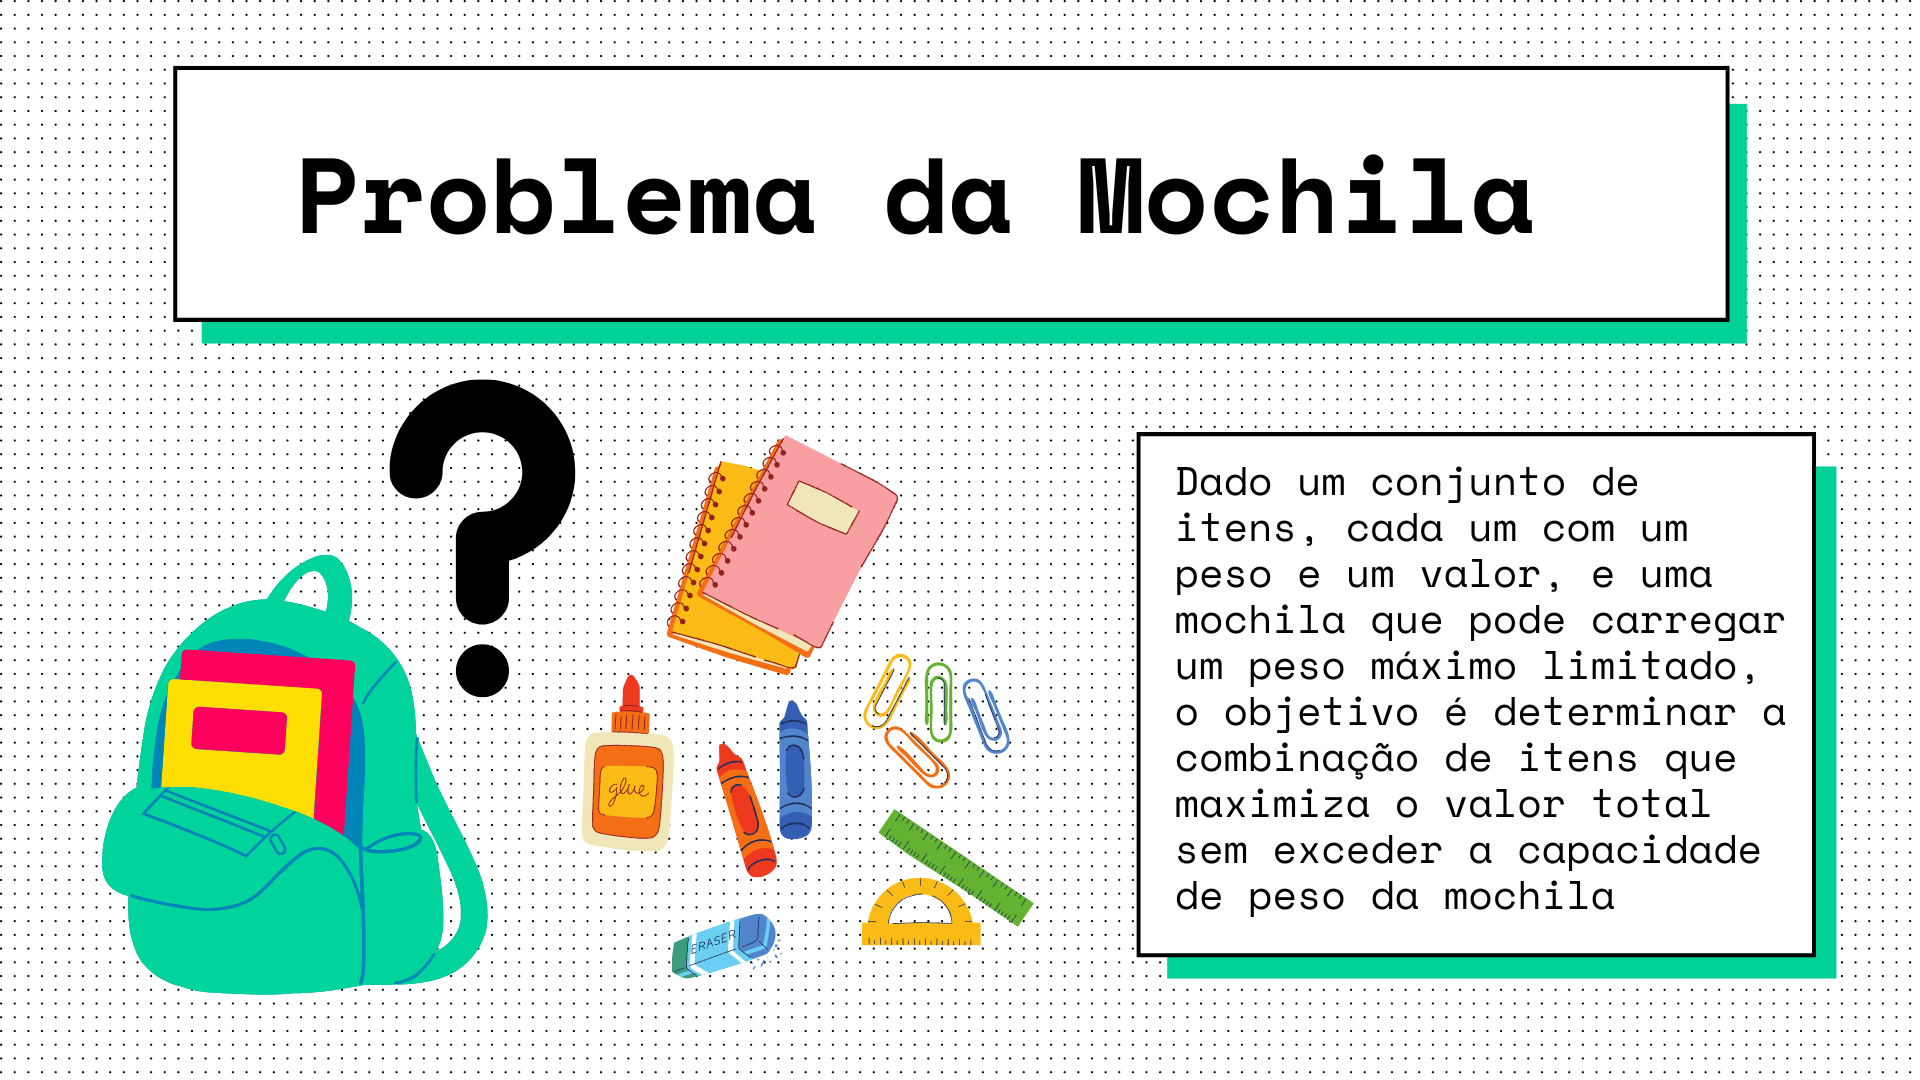

## Implementação algorítmo genético
- O algoritmo deve incluir pelo menos duas populações que trocam pelo menos um indivíduo a cada X gerações.
- Além disso, deve-se apresentar gráficos da fitness das gerações das duas populações, demarcando onde houve troca de indivíduos.
- Cada população deve ter os seus próprios operadores genéticos (seleção, mutação, crossover).

### Requisitos:
   - Utilizar a biblioteca DEAP para implementar o algoritmo genético e resolver o problema da mochila.
   - Implementar a troca de pelo menos um indivíduo entre as populações a cada X gerações (os alunos são encorajados a testar diferentes valores de X).
   - Apresentar gráficos mostrando a evolução da fitness nas duas populações.
   - Demarcar nos gráficos os pontos onde houve troca de indivíduos entre as populações.


## Instalação

In [ ]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 5.2 MB/s eta 0:00:00


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [ ]:
!gdown --id 1e-VAXfw_An8TJUnUgpfGd9lxzNmF6SoX

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1e-VAXfw_An8TJUnUgpfGd9lxzNmF6SoX
To: /content/knapsack.txt
100% 899/899 [00:00<00:00, 2.72MB/s]


### Bibliotecas

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from deap import base, creator, tools, algorithms
import pandas as pd
import random

## Instância do problema

Leitura dos dados do arquivo de texto que contém informações sobre itens do problema da mochila, onde cada linha do arquivo representa um item com um peso e um valor.

In [ ]:
dados_knapsack = pd.read_table("/content/knapsack.txt", delimiter=" ")

items = []
for index, row in dados_knapsack.iterrows():
    item = {"peso": row['weight'], "valor": row['value']}
    items.append(item)

print(f'Items: {items}')
print(f'Numero de Items: {len(items)}')

Items: [{'peso': 995, 'valor': 100}, {'peso': 485, 'valor': 94}, {'peso': 326, 'valor': 506}, {'peso': 248, 'valor': 416}, {'peso': 421, 'valor': 992}, {'peso': 322, 'valor': 649}, {'peso': 795, 'valor': 237}, {'peso': 43, 'valor': 457}, {'peso': 845, 'valor': 815}, {'peso': 955, 'valor': 446}, {'peso': 252, 'valor': 422}, {'peso': 9, 'valor': 791}, {'peso': 901, 'valor': 359}, {'peso': 122, 'valor': 667}, {'peso': 94, 'valor': 598}, {'peso': 738, 'valor': 7}, {'peso': 574, 'valor': 544}, {'peso': 715, 'valor': 334}, {'peso': 882, 'valor': 766}, {'peso': 367, 'valor': 994}, {'peso': 984, 'valor': 893}, {'peso': 299, 'valor': 633}, {'peso': 433, 'valor': 131}, {'peso': 682, 'valor': 428}, {'peso': 72, 'valor': 700}, {'peso': 874, 'valor': 617}, {'peso': 138, 'valor': 874}, {'peso': 856, 'valor': 720}, {'peso': 145, 'valor': 419}, {'peso': 995, 'valor': 794}, {'peso': 529, 'valor': 196}, {'peso': 199, 'valor': 997}, {'peso': 277, 'valor': 116}, {'peso': 97, 'valor': 908}, {'peso': 719, '

 Parâmetros utilizados para configurar e ajustar o algoritmo genético para resolver o problema da mochila:

In [ ]:
CAPACIDADE_MOCHILA = 1000
QUANTIDADE_GENES = len(items)
NUM_GERACOES = 150
X = 20 # A cada X gerações, ocorre a troca indivíduos entre populações

## Representação de um indivíduo
Cada indivíduo é representado por uma lista binária de tamanho igual ao número de itens. O valor 1 na posição i indica que o item i está na mochila, e 0 indica que não está.

Inicialmente, nossa estratégia foi gerar indivíduos aleatórios, mas ocorria que esses indivíduos excediam a capacidade da mochila. Isso resultava em soluções inválidas onde todas as soluções encontradas eram iguais a zero. Para tentar contornar esse problema, várias estratégias foram testadas. Inicialmente, foram explorados diferentes algoritmos de mutação, crossover e seleção, assim como ajustes na probabilidade e no número de gerações. No entanto, essas abordagens não resolveram efetivamente o problema de gerar indivíduos válidos.

A solução encontrada foi modificar o processo de geração dos indivíduos. Tentamos em um primeiro momento tentar gerar aleatoriamente até obter um indivíduo válido, o que foi extremamente lento. Para tentar otimizar a escolha de individuos válidos atribuimos uma baixa probabilidade de sortear números 1 (para evitar exceder a capacidade da mochila), entretanto mesmo com uma probabilidade de 0.15 ainda era muito lento e se tornava inviável a utilização deste método.

Dessa forma, criamos a função `generate_individual` que é um pouco mais inteligente: embaralhamos os índices dos itens disponíveis (genes) e então tentamos adicionar esses itens à mochila até que a capacidade máxima seja atingida. Isso garante que os indivíduos gerados sejam sempre válidos e que temos variedade dos indivíduos gerados, já que cada tentativa de preenchimento começa de uma ordem diferente dos itens.

In [ ]:
def generate_individual():
    individual = [0] * QUANTIDADE_GENES
    total_weight = 0

    indices = list(range(QUANTIDADE_GENES)) # Lista de índices embaralhados
    np.random.shuffle(indices)

    for i in indices:
        if total_weight + items[i]["peso"] <= CAPACIDADE_MOCHILA:
            individual[i] = 1
            total_weight += items[i]["peso"]

    return creator.Individual(individual)

## Avaliação da Fitness

Utilizamos a função de fitness fornecida pelo professor, no qual calcula o valor total dos itens na mochila e penaliza as soluções que excedem a capacidade máxima.



In [ ]:
def evaluate_knapsack(individual, items=items, capacity=CAPACIDADE_MOCHILA):
    total_weight = 0
    total_value = 0

    for i in range(len(individual)):
        if individual[i] == 1:
            total_weight += items[i]["peso"]
            total_value += items[i]["valor"]

    if total_weight > capacity:
        return 0,
    return total_value,

## Implementação Algorítmo genético

**Criando tipos**

A seguir definimos o problema de maximização da mochila e configuramos os indivíduos e a primeira população:

In [ ]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Problema de Maximização
creator.create("Individual", list, fitness=creator.FitnessMax)

In [ ]:
toolbox_1 = base.Toolbox()
toolbox_1.register("individual", generate_individual)
print(toolbox_1.individual())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
toolbox_1.register("population", tools.initRepeat, list, toolbox_1.individual)
population_1 = toolbox_1.population(n=100)

print(population_1)

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Realizamos o cruzamento de dois pontos, aplicamos a mutação que inverte bits e selecionamos indivíduos por meio de um torneio:

In [ ]:
toolbox_1.register("evaluate", evaluate_knapsack)
toolbox_1.register("mate", tools.cxTwoPoint)
toolbox_1.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox_1.register("select", tools.selTournament, tournsize=3)

Agora que a primeira população foi configurada, realizamos a configuração da segunda população utilizando algoritmos diferentes para mutação, crossover e seleção.

Foi utilizado o Crossover Ordenado, uma Mutação por Embaralhamento de Índices e a Seleção por roleta.

In [ ]:
toolbox_2 = base.Toolbox()
toolbox_2.register("individual", generate_individual)
toolbox_2.register("population", tools.initRepeat, list, toolbox_2.individual)
population_2 = toolbox_2.population(n=100)
toolbox_2.register("evaluate", evaluate_knapsack)
toolbox_2.register("mate", tools.cxOrdered)
toolbox_2.register("mutate", tools.mutShuffleIndexes, indpb=0.2)
toolbox_2.register("select", tools.selRoulette)

Configuramos as estatísticas para serem coletadas durante a execução do algoritmo, como a média e desvio padrão dos valores de fitness da população:

In [ ]:
def saveStatistics(individual):
  return (individual.fitness.values)

estatistica = tools.Statistics(saveStatistics)
estatistica.register("mean", np.mean)

std_1 = []
std_2 = []
mean_1 = []
mean_2 = []

A seguir temos a implementação do algoritmo genético, que possui duas populações que evoluem independentemente com a troca de indivíduos entre populações em intervalos regulares.

In [ ]:
# Variáveis para armazenar a evolução da fitness
fitness_1 = []
fitness_2 = []
points_swap = []

# Algoritmo Genético com troca de indivíduos
for gen in range(NUM_GERACOES):
    result_1, log_1 = algorithms.eaSimple(population_1, toolbox_1, cxpb=0.7, mutpb=0.2, ngen=1, verbose=False, stats=estatistica)
    result_2, log_2 = algorithms.eaSimple(population_2, toolbox_2, cxpb=0.7, mutpb=0.2, ngen=1, verbose=False, stats=estatistica)

    population_1 = toolbox_1.select(population_1, len(population_1))
    population_2 = toolbox_2.select(population_2, len(population_2))

    if (gen+1) % X == 0: # Swap population: pegar o melhor individuo de cada população e troca pelo pior
      population_1[-1] = tools.selBest(population_2, 1)[0]
      population_2[-1] = tools.selBest(population_1, 1)[0]
      points_swap.append(gen)

    fitness_1.append(tools.selBest(population_1, 1)[0])
    fitness_2.append(tools.selBest(population_2, 1)[0])

    mean_1.append(log_1.select("mean")[0])
    mean_2.append(log_2.select("mean")[0])
    std_1.append(np.std([ind.fitness.values[0] for ind in population_1]))
    std_2.append(np.std([ind.fitness.values[0] for ind in population_2]))


### Resultados

Abaixo temos a solução encontrada para o problema da mochila. Cada elemento no vetor corresponde a um item específico, onde 1 indica que o item está na mochila e 0 indica que não está.

Também apresentamos o valor de fitness do melhor indivíduo que representa a utilidade máxima obtida pela combinação de itens na mochila, considerando a restrição de capacidade.

In [ ]:
best_ind_1 = tools.selBest(population_1, 1)[0]
print(f"Best is {best_ind_1}, \n{evaluate_knapsack(best_ind_1)}")

Best is [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
(7818,)


In [ ]:
best_ind_2 = tools.selBest(population_2, 1)[0]
print(f"Best is {best_ind_2}, \n{evaluate_knapsack(best_ind_2)}")

Best is [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
(7588,)


Os resultados mostram que o algoritmo genético conseguiu encontrar uma solução viável e eficiente para o problema da mochila, maximizando o valor total dos itens sem exceder a capacidade da mochila.

Durante nossas simulações, observou-se que cada população gerada apresentou resultados diferentes a cada execução devido à natureza estocástica dos algoritmos evolutivos. A aleatoriedade é inerente a esses algoritmos, pois fatores como a seleção aleatória de pais, operadores de mutação e crossover baseados em probabilidades, e a geração inicial aleatória da população introduzem variabilidade nos resultados. Nas simulações realizadas, a primeira população frequentemente obteve melhores resultados em termos de qualidade da solução geral. Esse desempenho superior pode ser atribuído a uma configuração de parâmetros que favoreceu uma exploração mais eficaz do espaço de soluções e uma adaptação mais eficiente às características específicas do problema de otimização.

#### Gráfico

Também geramos um gráfico mostrando a evolução das médias das populações ao longo das gerações, com sombreado de erro para indicar a variação das médias. As linhas verticais cinzas marcam os pontos onde ocorreu a troca de indivíduos entre as populações.

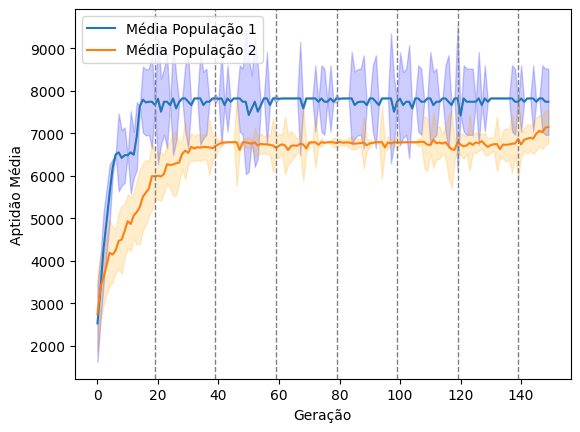

In [ ]:
generations = range(NUM_GERACOES)
mean_1 = np.array(mean_1)
mean_2 = np.array(mean_2)
std_1 = np.array(std_1)
std_2 = np.array(std_2)

plt.plot(mean_1, label="Média População 1")
plt.plot(mean_2, label="Média População 2")

plt.fill_between(generations, mean_1 - std_1, mean_1 + std_1, color='blue', alpha=0.2)
plt.fill_between(generations, mean_2 - std_2, mean_2 + std_2, color='orange', alpha=0.2)

for point in points_swap:
    plt.axvline(x=point, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Geração")
plt.ylabel("Aptidão Média")
plt.legend()
plt.show()

No gráfico analisado, é possível observar diferenças marcantes na evolução das duas populações. A primeira população demonstra um desempenho superior em geral, encontrando soluções melhores e mantendo uma linha de aptidão média mais estável ao longo das gerações. Isso sugere que a configuração dos operadores e parâmetros dessa população facilitou uma exploração mais eficiente do espaço de soluções e uma adaptação mais eficaz às características do problema.

Por outro lado, a segunda população, embora pareça apresentar erros menores, resulta em soluções de menor qualidade. Isso pode indicar que a abordagem utilizada para essa população, embora tenha introduzido menos variação e, portanto, menos erros, também foi menos capaz de explorar e explorar efetivamente o espaço de soluções, resultando em um desempenho inferior.

### Modificando parâmetros

#### Aumentando o número de gerações
- Valor anterior: 150

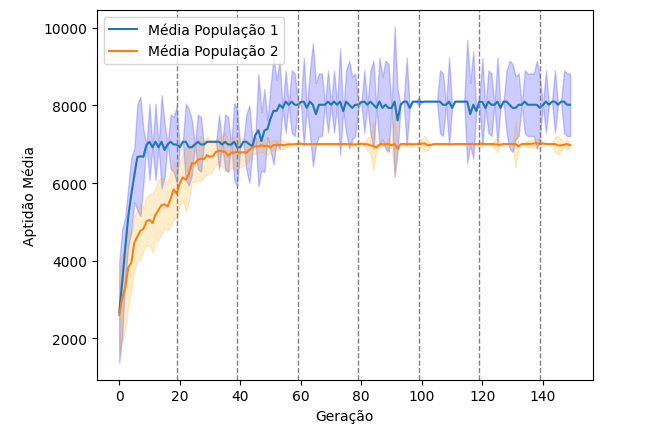


- Novo: 300

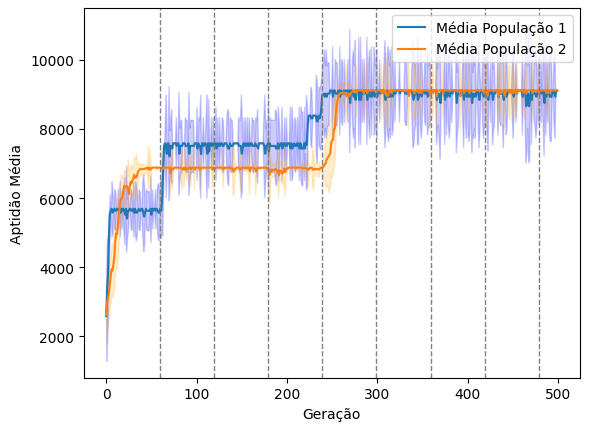

Ao aumentar o número de gerações, observa-se que ambas as populações se estabilizam em termos de aptidão média. Isso ocorre porque as populações têm mais tempo para evoluir, permitindo que as melhores soluções sejam selecionadas e refinadas ao longo do tempo.

Além disso, as duas acabam encontrando um melhor resultado que anteriormente. Isso ocorre pois a  população tem mais oportunidades de explorar o espaço de soluções e de realizar mutações e cruzamentos que possam levar a melhores indivíduos. Mas ainda assim, a primeira população apresenta resultados melhores




#### Colocar mais troca de individuos x nenhuma troca

*   Nenhuma troca

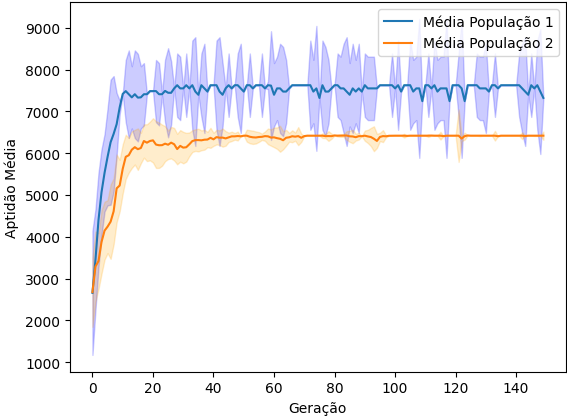

*   A cada 5 gerações

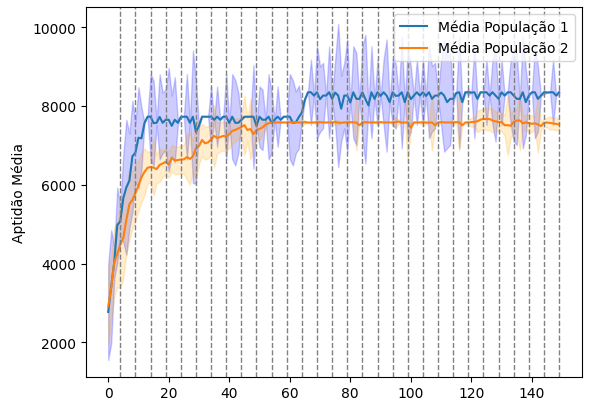



A análise dos gráficos mostra que a troca de indivíduos entre duas populações a cada 5 gerações resulta em uma aptidão média mais alta e equilibrada para ambas as populações, comparado à ausência de trocas. A variabilidade é maior durante as gerações com trocas, mas diminui ao longo do tempo, indicando que a troca de indivíduos promove maior diversidade genética e melhora a eficiência do algoritmo, evitando a convergência prematura e permitindo uma exploração mais eficaz do espaço de soluções.

Em resumo a troca entre os indivíduos da população fez com que aumentasse a diversidade genética e melhorarasse a qualidade das soluções, enquanto que com nenhuma troca pode levar a especializações distintas entre as populações